In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemFD, GlobalEM1DSurveyFD, get_vertical_discretization_frequency
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import empymod

# Seting up a 2D mesh and model

In [3]:
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.01)

In [4]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [5]:
n_sounding = 20
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 0.1
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()
chi = np.zeros_like(sigma_em1d)
# chi[poly_inds] = 0.005

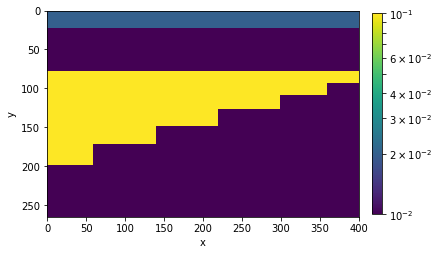

In [6]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [7]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [10]:
mapping = Maps.ExpMap(mesh)
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "ppm",
    field_type = 'secondary',
    topo = topo
)
prob = GlobalEM1DProblemFD(
    mesh, sigmaMap=mapping, chi=chi, hz=hz, parallel=True, n_cpu=2, verbose=True,
    Solver=PardisoSolver
)
prob.pair(survey)
m = np.log(sigma_em1d)
prob.model = m

>> Use multiprocessing for parallelization
>> n_cpu: 2


In [11]:
%%time
dobs = survey.makeSyntheticData(m, std=0.15, force=True)

Compute fields
>> Compute response
CPU times: user 57.1 ms, sys: 16.5 ms, total: 73.7 ms
Wall time: 187 ms


Text(0,0.5,'Hz/Hp (ppm)')

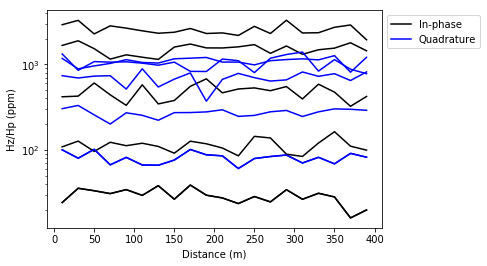

In [12]:
DOBS = dobs.reshape(( prob.n_sounding, 2, survey.n_frequency))
i_freq=0
plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')    
plt.legend(("In-phase", "Quadrature"), bbox_to_anchor=(1,1))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')    
plt.xlabel("Distance (m)")
plt.ylabel("Hz/Hp (ppm)")

In [13]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)
from simpegEM1D import get_2d_mesh, LateralConstraint

In [14]:
hz.shape[0]

19

In [15]:
def run_inversion(option=None):
    mesh_reg = get_2d_mesh(n_sounding, hz)
    regmap = Maps.IdentityMap(mesh_reg)
    # mapping is required ... for IRLS
    reg = LateralConstraint(
        mesh_reg, mapping=regmap,
        alpha_s=1.,
        alpha_x = 10.,
        alpha_y = 1.
    )
    xy = Utils.ndgrid(np.arange(n_sounding), np.r_[0.])
    reg.get_grad_horizontal(xy, hz, dim=2, use_cell_weights=True)
    std = 0.15
    floor = 0.
    np.random.seed(1)
    uncert = std*abs(dobs)+floor
    m0 = np.ones(mesh_reg.nC) * np.log(1./50.)
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    p = 0
    qx, qz = 1., 1.
    reg.norms = np.c_[p, qx, qz, 0.]
    IRLS = Directives.Update_IRLS(
        maxIRLSiter=10, minGNiter=1, fix_Jmatrix=True, betaSearch=False
    )
    opt = Optimization.InexactGaussNewton(maxIter = 10)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
    target = Directives.TargetMisfit()
    if option is None:
        reg.alpha_x=0.
        inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])        
    elif option == "l2":
        reg.alpha_x=10.        
        inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
    elif option == "l0":
        inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
    prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
    print (reg.cell_weights)
    mopt = inv.run(m0)    
    return mopt, invProb.dpred

In [16]:
mopt_none, pred = run_inversion(option=None)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
[ 3.48836156  3.96439617  4.5053922   5.12021454  5.81893779  6.61301138
  7.51544715  8.54103263  9.70657325 11.03116783 12.53652144 14.24730111
 16.19154006 18.40109698 20.91217814 23.76593064 27.00911667 30.69487976
 34.88361559  3.48836156  3.96439617  4.5053922   5.12021454  5.81893779
  6.61301138  7.51544715  8.54103263  9.70657325 11.03116783 12.53652144
 14.24730111 16.19154006 18.40109698 20.91217814 23.76593064 27.00911667
 30.69487976 34.88361559  3.48836156  3.96439617  4.5053922   5.12021454
  5.81893779  6.61301138  7.51544715  8.54103263  9.70657325 11.03116783
 12.53652144 14.24730111 16.19154006 18.40109698 20.91217814 23.76593064
 27.00911667 30.69487976 34.88361559  3.48836156  3.96439617  4.5053922
  5.12021454  5.81893779  6.61301138  7.51544715  8.54103263  9.70657325
 11.03116783 12.53652144 14.24730111 16.19154006 18.40109698 20.91217814
 23.76593064 27.00911667 30.69487976 34.88361559  3.

In [17]:
mopt_l2, pred = run_inversion(option='l2')

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
[ 3.48836156  3.96439617  4.5053922   5.12021454  5.81893779  6.61301138
  7.51544715  8.54103263  9.70657325 11.03116783 12.53652144 14.24730111
 16.19154006 18.40109698 20.91217814 23.76593064 27.00911667 30.69487976
 34.88361559  3.48836156  3.96439617  4.5053922   5.12021454  5.81893779
  6.61301138  7.51544715  8.54103263  9.70657325 11.03116783 12.53652144
 14.24730111 16.19154006 18.40109698 20.91217814 23.76593064 27.00911667
 30.69487976 34.88361559  3.48836156  3.96439617  4.5053922   5.12021454
  5.81893779  6.61301138  7.51544715  8.54103263  9.70657325 11.03116783
 12.53652144 14.24730111 16.19154006 18.40109698 20.91217814 23.76593064
 27.00911667 30.69487976 34.88361559  3.48836156  3.96439617  4.5053922
  5.12021454  5.81893779  6.61301138  7.51544715  8.54103263  9.70657325
 11.03116783 12.53652144 14.24730111 16.19154006 18.40109698 20.91217814
 23.76593064 27.00911667 30.69487976 34.88361559  3.

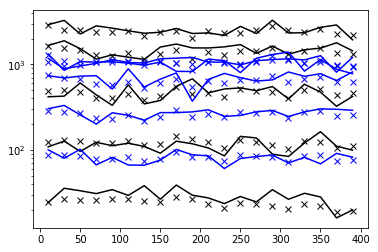

In [18]:
DOBS = dobs.reshape((prob.n_sounding, 2, survey.n_frequency))
DPRED = pred.reshape((prob.n_sounding, 2, survey.n_frequency))
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,0,i_freq], 'k')
    plt.semilogy(mesh.vectorCCx, DPRED[:,0,i_freq], 'kx')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, DOBS[:,1,i_freq], 'b')
    plt.semilogy(mesh.vectorCCx, DPRED[:,1,i_freq], 'bx')

In [19]:
sigma_est_none = Utils.mkvc((np.exp(mopt_none)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2 = Utils.mkvc((np.exp(mopt_l2)).reshape((prob.n_sounding, prob.n_layer)))
# sigma_est_l2 = Utils.mkvc((np.exp(invProb.l2model)).reshape((prob.n_sounding, prob.n_layer)))

In [20]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

Text(0.5,1,'Recovered model')

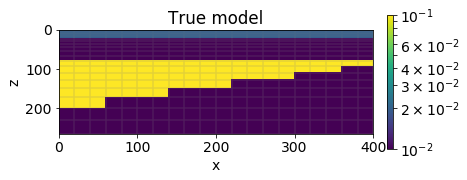

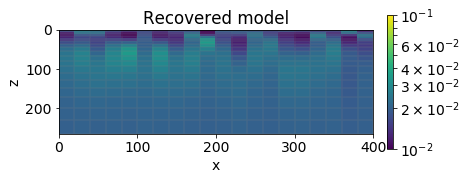

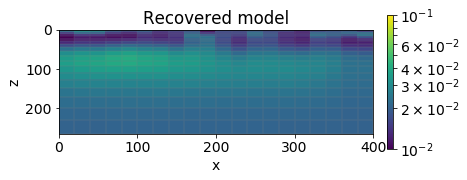

In [21]:
cb = plt.colorbar(
    mesh.plotImage(
        sigma, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylabel("z")
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)

plt.title("True model")

cb = plt.colorbar(
    mesh.plotImage(
        sigma_est_none, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.title("Recovered model")
plt.ylabel("z")
# plt.title("Laterally-contrained model: L2 L2")
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)


cb = plt.colorbar(
    mesh.plotImage(
        sigma_est_l2, grid=True, clim=(1e-2, 1e-1), pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.ylabel("z")
plt.gca().set_aspect(0.5)
# plt.title("Laterally-contrained model: L0 L2")
plt.title("Recovered model")

In [22]:
from simpegEM1D import ModelIO

In [23]:
sigma_est_l2.shape

(380,)

In [24]:
np.ones(x.shape[0], dtype=int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
sigma_est_l2.shape

(380,)

In [26]:
IO = ModelIO(
    line=np.ones(x.shape[0], dtype=float),
    hz=hz,    
    physical_property=mapping*mopt_l2,        
    topography=np.c_[x, np.zeros(x.shape[0]), np.zeros(x.shape[0])],            
)

/Users/sgkang/Projects/simpegEM1D/simpegEM1D/IO.py:55: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


(<matplotlib.collections.PathCollection at 0x1a1eff8b00>,
 <matplotlib.colorbar.Colorbar at 0x1a1ffb6f28>)

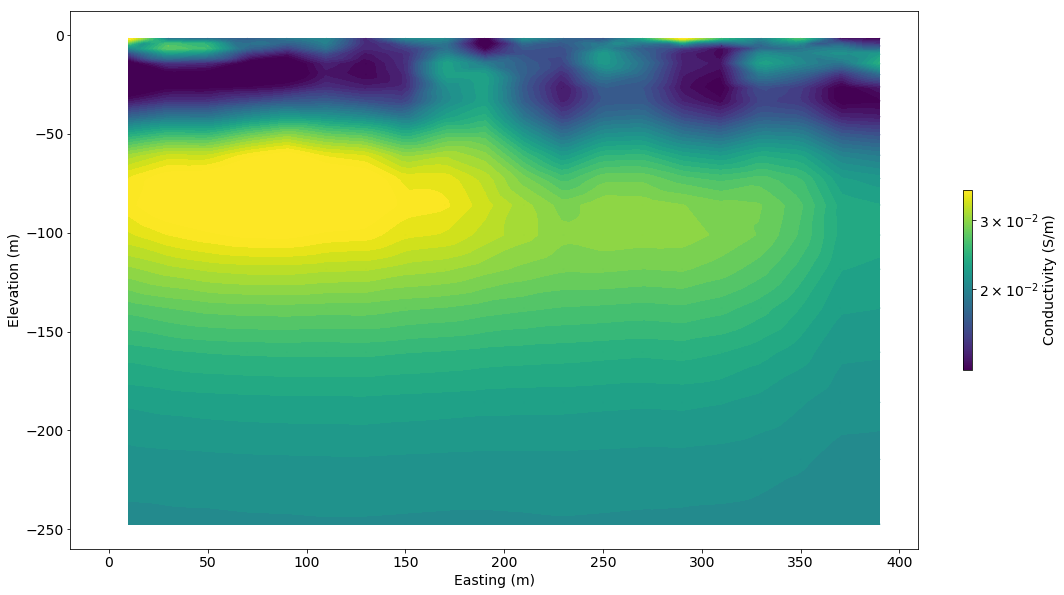

In [27]:
IO.plot_section(plot_type='contour', i_line=0)

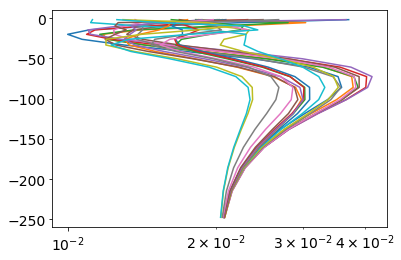

In [28]:
from simpegEM1D import plotLayer, set_mesh_1d
mesh_1d = set_mesh_1d(hz)
out = plt.plot(IO.physical_property_matrix, -mesh_1d.vectorCCx)
plt.xscale('log')